## Read the KFOLD Training Output and Get the Mean Performance and Uncertainties 

Y_test.shape= (88000, 5)
Y_predict.shape= (88000, 5)
idx= [0 0 1 ... 0 0 4]
preds.shape= (88000, 5)
label= gluon
auc  = 0.8294307529677617
 
label= quark
auc  = 0.8743732410660146
 
label= W
auc  = 0.9023130166802746
 
label= Z
auc  = 0.8862058850424707
 
label= top
auc  = 0.9176034357996791
 
Y_test.shape= (88000, 5)
Y_predict.shape= (88000, 5)
idx= [1 3 3 ... 0 2 1]
preds.shape= (88000, 5)
label= gluon
auc  = 0.8374780663481093
 
label= quark
auc  = 0.875412574355995
 
label= W
auc  = 0.9056703899697192
 
label= Z
auc  = 0.8852088203582686
 
label= top
auc  = 0.9190541865833768
 
Y_test.shape= (88000, 5)
Y_predict.shape= (88000, 5)
idx= [2 1 4 ... 4 4 2]
preds.shape= (88000, 5)
label= gluon
auc  = 0.8331235781119746
 
label= quark
auc  = 0.8745345851303665
 
label= W
auc  = 0.9047916153581039
 
label= Z
auc  = 0.8863058853486281
 
label= top
auc  = 0.9184299175632245
 
Y_test.shape= (88000, 5)
Y_predict.shape= (88000, 5)
idx= [1 4 0 ... 4 0 0]
preds.shape= (88000, 5)
label= gluon
auc

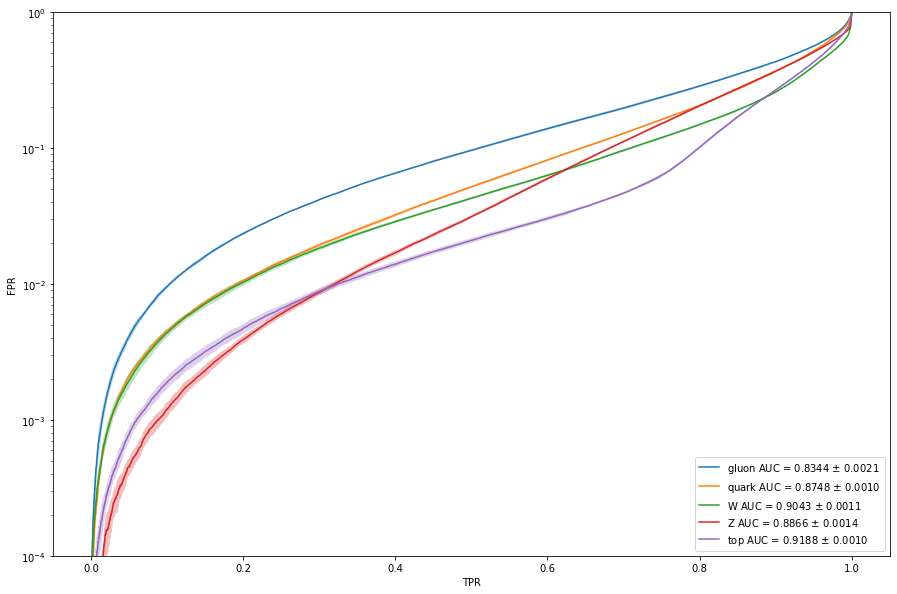

In [1]:
#!/usr/bin/env python
# coding: utf-8


import numpy as np
import h5py
import os
import numpy as np
import itertools
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc, precision_recall_curve, accuracy_score
import matplotlib.pyplot as plt
from math import log
import sys
import joblib


# Load the data and for the given fold
nfolds=10
nbits=8


################################################


# Load targets and test data index
arch = 'QGarnet'
path='/Users/sznajder/WorkM1/workdir/notebooks/QKeras/results/kfold/{}/'.format(arch)

test_idx = joblib.load(path+'test_idx_kfold_%s.dat' %(nfolds))
Y = joblib.load(path+'Y_kfold_%s.dat' %(nfolds))



# Create lists of dictionaries
tprs=[]
fprs=[]
tresholds=[]
aucs=[]
accs=[]
labels = ['gluon', 'quark', 'W', 'Z', 'top']


# Loop over folds
for ifold in range(nfolds):

#   Get the data targets for the given fold
    Y_test =  Y[test_idx[ifold]]
    print('Y_test.shape=',Y_test.shape)


#   Get model predictions for the given fold ( each fold trained as independent condor job )
    Y_predict = joblib.load(path+'Y_predict_garnet_fold_%s_nbits_%s.dat' %(ifold,nbits))
    print('Y_predict.shape=',Y_predict.shape)


#   Convert classifier real number predictions(scores) into integers scores(0 or 1) for getting the accuracy estimate
    preds = np.zeros(Y_predict.shape)       # create an empty array for the integer scores
    idx = np.argmax(Y_predict, axis=1)      # get the index of the highest scoring class for a jet 
    preds[np.arange(len(preds)), idx] = 1   # set the prediction to 1 for the highest score class
    print('idx=',idx)
    print('preds.shape=',preds.shape)

    #   Create dictionaries containers for each label
    tpr={}
    fpr={}
    tresh={}
    auc1={}
    acc={}

#   Loop over classes(labels) to get metrics per class
    for i, label in enumerate(labels):

        # Get the FPR , TPR and ROC AUC metrics for a given label
        fpr[label], tpr[label], tresh[label] = roc_curve(Y_test[:,i], Y_predict[:,i])
        auc1[label] = auc( fpr[label] , tpr[label] )
        acc[label] = accuracy_score( Y_test[:,i], preds[:,i]  )
        print('label=',label)
        print('auc  =',auc1[label])
        print(' ')
    # Append the metrics dictionaries to the list of folds iterations
    tprs.append(tpr)
    fprs.append(fpr)
    tresholds.append(tresh)
    aucs.append(auc1)
    accs.append(acc)
        

# Plot performance associated to KFold

# Plot the ROC curves
plt.figure(figsize=(15,10))
ax = plt.subplot(1,1,1)

# Create a sample of npoints along FPR axis 
npoints = 5000
base_tpr = np.exp(np.linspace(log(0.00005), 0., npoints))

# Create dictionaries for metric containers per label
fpr_mean = {}
fpr_std = {}
fpr_upper = {}
fpr_lower = {}
auc_mean = {}
auc_std = {}
acc_mean = {}
acc_std = {}


# Loop over labels and folds to get MEAN and STD over folds
for label in labels:
    fpr_array = np.array([])
    auc_array = np.array([])
    acc_array = np.array([])


    for ifold in range(nfolds):
        # Javier's interpolation to take into account different tresholds for ROCs of different folds   
        this_fpr = np.array( fprs[ifold][label] )
        this_tpr = np.array( tprs[ifold][label] )
        # Linear Interpolation between base_tpr points
        fpr_interp = np.interp(base_tpr, this_tpr, this_fpr)
        fpr_interp = fpr_interp.reshape((1,npoints))
        fpr_array = np.concatenate([fpr_array, fpr_interp], axis=0) if fpr_array.size else fpr_interp
        auc_array = np.append(auc_array, aucs[ifold][label]) 
        acc_array = np.append(acc_array, accs[ifold][label]) 

    
    # Get the mean and std for: TPR , TPR upper bound, TPR lower bound, AUC and ACCURACY
    fpr_mean[label]  = np.mean(fpr_array, axis=0)
    fpr_std[label]   = np.std(fpr_array, axis=0)
    fpr_upper[label] = np.minimum(fpr_mean[label]+fpr_std[label], np.ones(npoints))
    fpr_lower[label] = np.maximum(fpr_mean[label]-fpr_std[label], np.zeros(npoints))
    auc_mean[label]  = np.mean( auc_array )
    auc_std[label]   = np.std(  auc_array )
    acc_mean[label]  = np.mean( acc_array )
    acc_std[label]   = np.std(  acc_array )
    
    print( 'fpr_upper=',fpr_upper[label] )
    print( 'fpr_mean=',fpr_mean[label] )
    print( 'fpr_lower=',fpr_lower[label] )
    print( 'label={} , AUC_mean={} '.format(label,auc_mean[label]) )
    print( 'label={} , AUC_std={} '.format(label,auc_std[label]) )
    print( 'label={} , ACC_mean={} '.format(label,acc_mean[label]) )
    print( 'label={} , ACC_std={} '.format(label,acc_std[label]) )




    ax.plot(base_tpr,fpr_mean[label],label='%s AUC = %.4f $\pm$ %.4f' %(label,auc_mean[label],auc_std[label]), linewidth=1.5)
    ax.fill_between(base_tpr, fpr_lower[label] , fpr_upper[label], alpha=0.3)

ax.semilogy()
ax.set_ylabel("FPR")
ax.set_xlabel("TPR")
ax.set_ylim(0.0001,1.0)
#ax.set_grid(True)
ax.legend(loc='lower right')

# Set model and output name
fname = arch+'_nconst_8_KFold_'+str(nfolds)+'_nbits_'+str(nbits)
print('Saving Plot : ',fname)
print(' ')
print(' ')
print(' ')
# Save plots
#fig.savefig(fname+'.pdf')
plt.savefig(fname+'.pdf', bbox_inches='tight')


## Save performance in CSV files  

In [2]:
# Save FPR for a given TPR value ( 30% , 50% & 80%)
with open('FPR@TPR_'+fname+'.csv', 'w') as file:
  file.write("model,label,tpr,fpr_mean,fpr_std \n")
  for label in labels:
    for t in [0.3, 0.5, 0.8]:
      index = np.argmax(base_tpr>t)  # get the array index for the given TPR woking point
      file.write( arch+', '+label+', '+str(t)+', '+str(fpr_mean[label][index])+', '+str(fpr_std[label][index])+'\n' )
               
               
# Save ROC AUC mean and std for each label
with open('ROCAUC_'+fname+'.csv', 'w') as file:
  file.write("model,label,AUC_mean,AUC_std\n")
  for label in labels:
      file.write( arch+', '+label+', '+str(auc_mean[label])+', '+str(auc_std[label])+'\n' )



# Save NN Accuracy for treshold of 0.5 for each label and the average over all classes
with open('ACCURACY_'+fname+'.csv', 'w') as file:
  file.write("model,label,Accuracy_mean,Accuracy_std\n")
  for label in labels:
      file.write( arch+', '+label+','+', '+str(acc_mean[label])+', '+str(acc_std[label])+'\n' )

    